Brief description of the problem and data

The text discusses the intersection of art and technology, focusing on how generative adversarial networks (GANs) can replicate the distinct styles of artists like Claude Monet. It highlights the advancements in computer vision that enabled the creation of original paintings or enhanced photos in Monet's style. The project encourages exploration of whether these data science techniques can produce artworks that classifiers might mistake for genuine Monet pieces, posing an exciting challenge.

In [1]:
# unzip the data
# import zipfile

# with zipfile.ZipFile('/workspaces/GANs-coursera/data/gan-getting-started.zip', 'r') as zip_ref:
#     zip_ref.extractall('/workspaces/GANs-coursera/data/')

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()


REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')
AUTO = tf.data.experimental.AUTOTUNE

REPLICAS: 1


In [4]:
# Set parameters
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
EPOCHS = 50
BATCH_SIZE = 1

EDA

In [5]:
# Define file paths
monet_tfrec_directory = './data/monet_tfrec'
photo_tfrec_directory = './data/photo_tfrec'
monet_jpg_directory = './data/monet_jpg'
photo_jpg_directory = './data/photo_jpg'
# Define functions to get image paths
def getImagePaths(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names
monet_images_path = getImagePaths(monet_jpg_directory)
photo_images_path = getImagePaths(photo_jpg_directory)
monet_tfrec_path = getImagePaths(monet_tfrec_directory)
photo_tfrec_path = getImagePaths(photo_tfrec_directory)
# Print the number of images and tfrec files
print(f"Number of Monet images: {len(monet_jpg_directory)}\n")
print(f"Number of Photo images: {len(photo_jpg_directory)}\n")
print(f"Number of Monet tfrec: {len(monet_tfrec_directory)}\n")
print(f"Number of Photo tfrec: {len(photo_tfrec_directory)}\n")

Number of Monet images: 16

Number of Photo images: 16

Number of Monet tfrec: 18

Number of Photo tfrec: 18



In [6]:
# Load and preprocess images
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(128, 128))  # Changed from 256x256
    img_array = img_to_array(img)
    img_array = (img_array - 127.5) / 127.5  # Normalize to [-1, 1]
    return img_array

images = np.array([load_and_preprocess_image(img) for img in monet_images_path])
print(f'Images shape: {images.shape}')

Images shape: (300, 128, 128, 3)


In [7]:
# Display images
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [8]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord)
    return dataset

In [9]:
# Load datasets
monet_ds = load_dataset(monet_tfrec_path, labeled=True).batch(100, drop_remainder=True)
photo_ds = load_dataset(photo_tfrec_path, labeled=True).batch(100, drop_remainder=True)

2024-12-04 08:45:29.909436: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-12-04 08:45:29.909465: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-12-04 08:45:29.909468: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-12-04 08:45:29.909495: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-04 08:45:29.909506: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


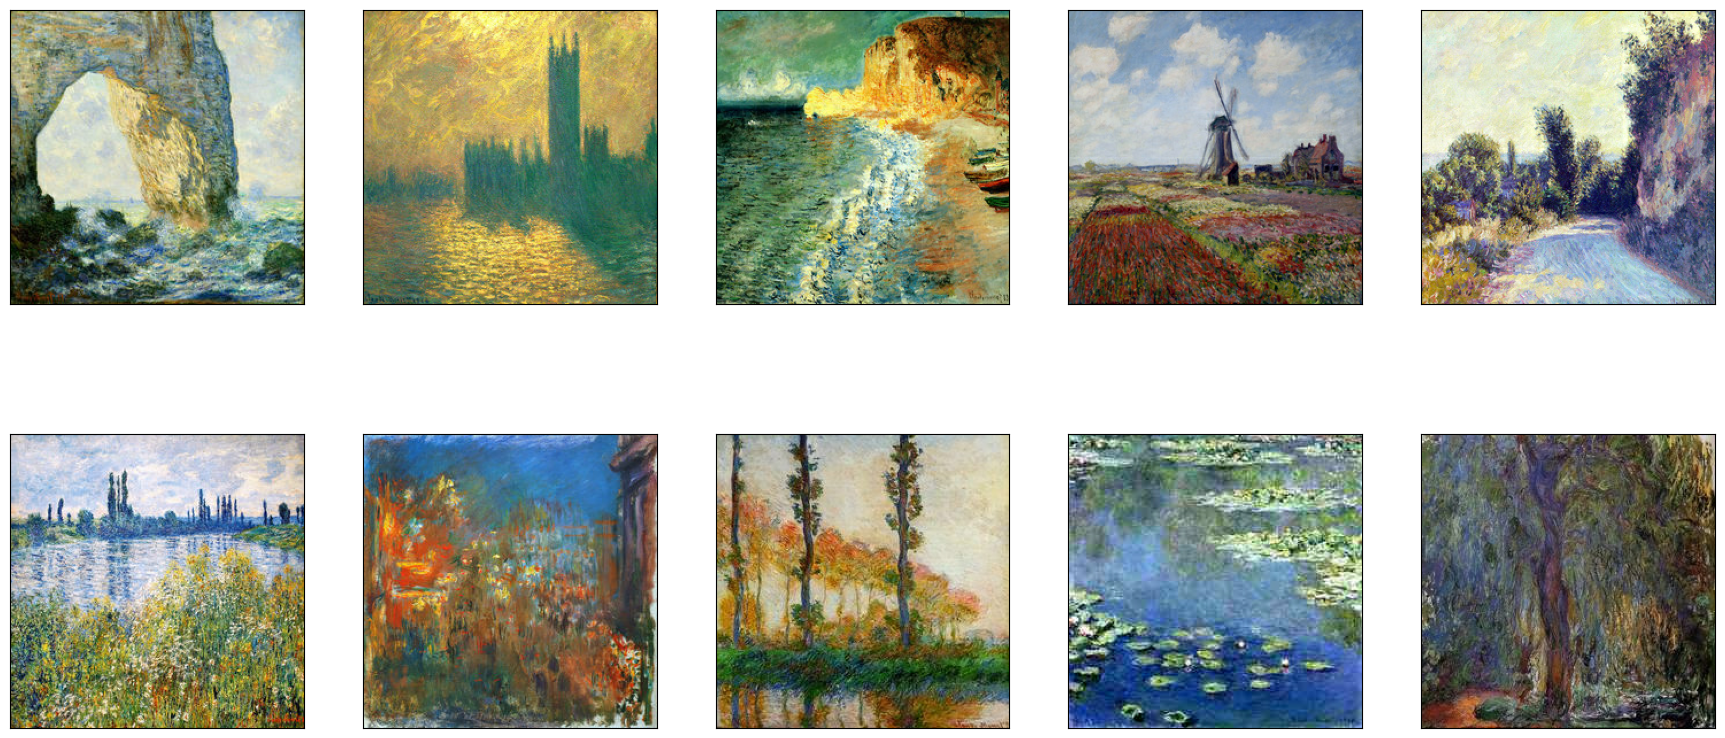

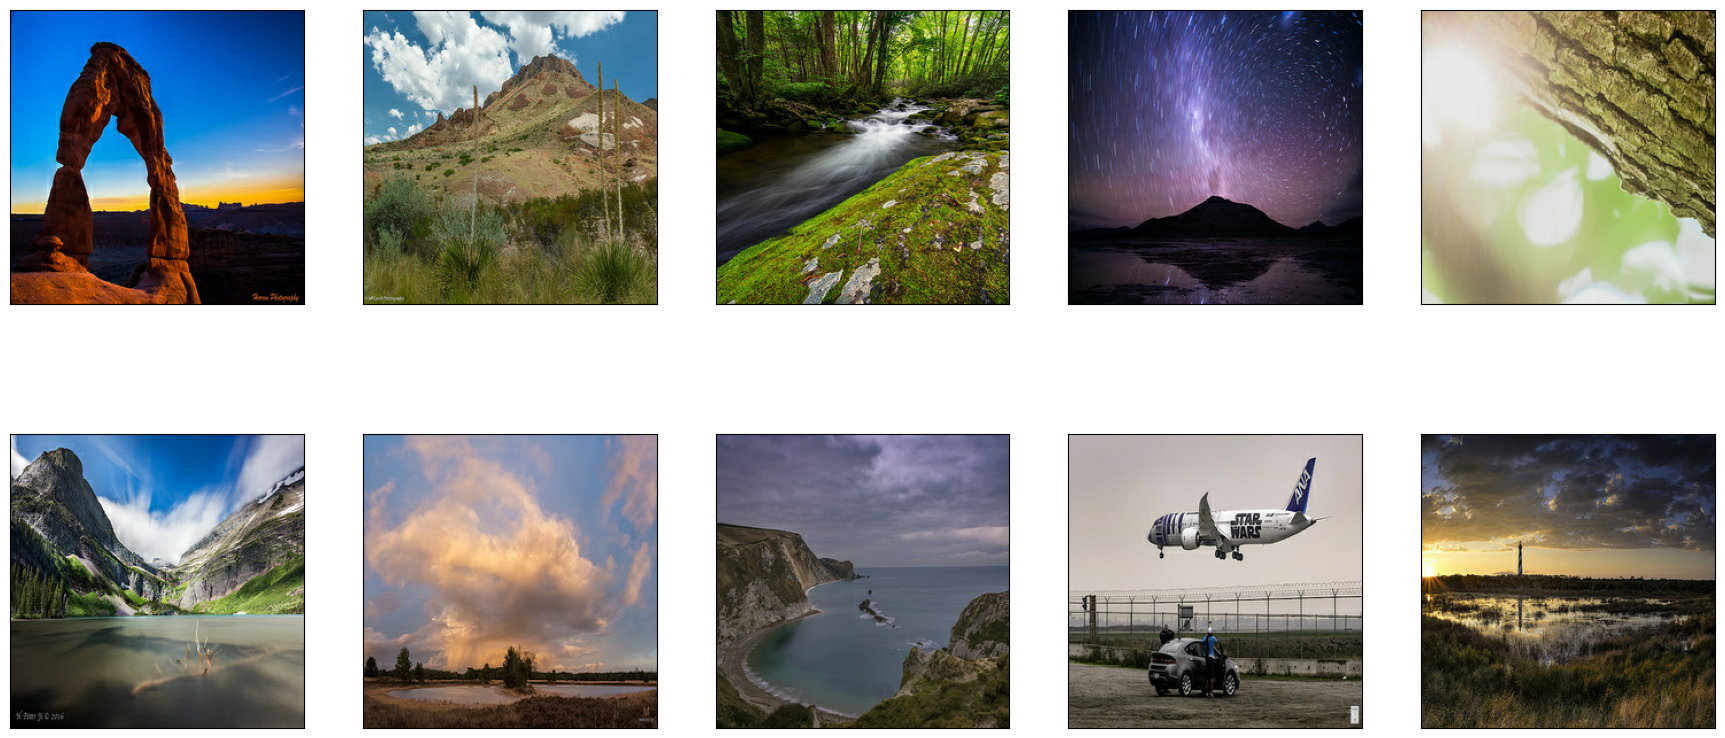

In [10]:
# Display images
def view_image(ds, rows=2):
    image = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()

    fig = plt.figure(figsize=(22, rows * 5.05 ))
    for i in range(5 * rows):
        ax = fig.add_subplot(rows, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i] / 2 + .5)
# Display Monet and Photo images
view_image(monet_ds)
view_image(photo_ds)

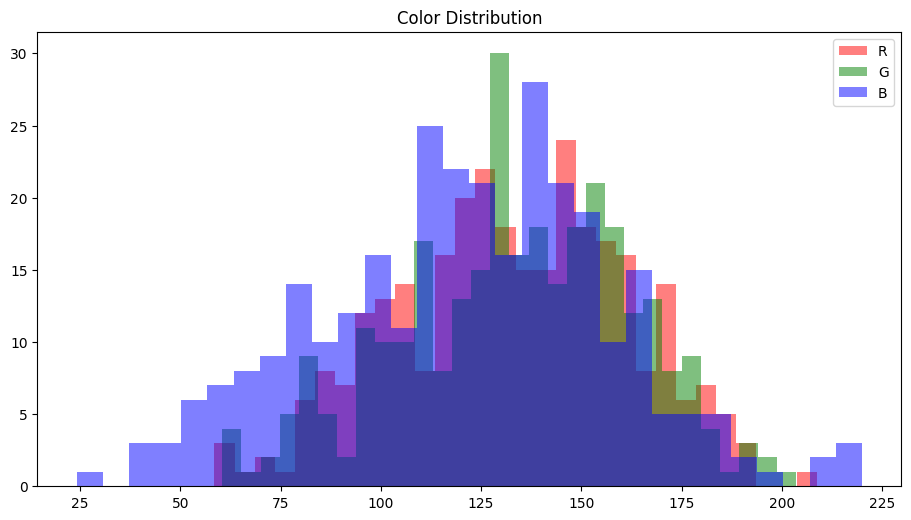

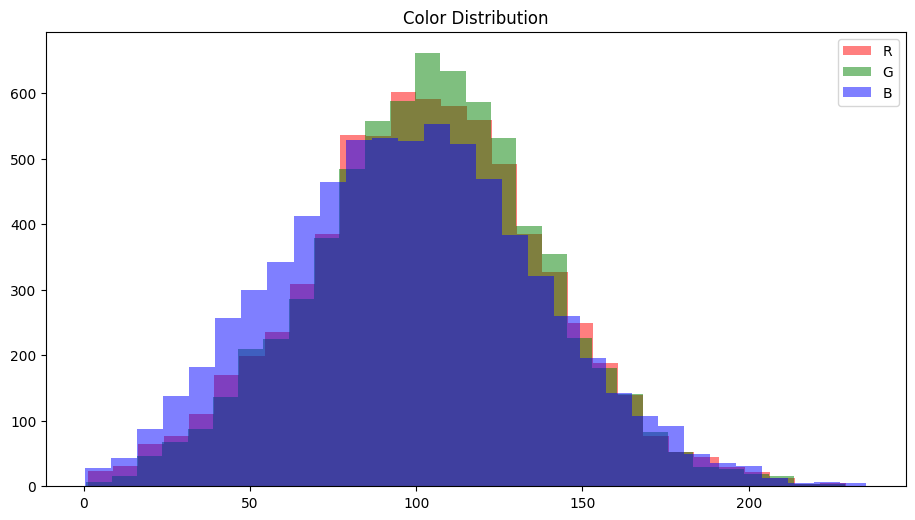

In [11]:
from PIL import Image
# Analyze images
def analyze_images(directory):
    files = [f for f in os.listdir(directory) if f.lower().endswith(('jpg'))]
    color_distributions = []

    for file_name in files:
        file_path = os.path.join(directory, file_name)
        with Image.open(file_path) as img:
            color_distributions.append(np.array(img).mean(axis=(0, 1)))

    return color_distributions
# Plot analysis
def plot_analysis(color_distributions):    
    plt.figure(figsize=(18, 10))
    plt.subplot(2, 2, 1)
    color_distributions = np.array(color_distributions)
    if color_distributions.ndim == 2:
        plt.hist(color_distributions[:, 0], bins=30, color='red', alpha=0.5, label='R')
        plt.hist(color_distributions[:, 1], bins=30, color='green', alpha=0.5, label='G')
        plt.hist(color_distributions[:, 2], bins=30, color='blue', alpha=0.5, label='B')
        plt.legend()
        plt.title('Color Distribution')
    else:
        plt.hist(color_distributions, bins=30, color='gray', alpha=0.7)
        plt.title('Gray-scale Distribution')

    plt.tight_layout()
    plt.show()

# Analyze Monet and Photo images
color_distributions = analyze_images(monet_jpg_directory)
plot_analysis(color_distributions)

color_distributions = analyze_images(photo_jpg_directory)
plot_analysis(color_distributions)

In [12]:
# Define the output channels
OUTPUT_CHANNELS = 3
# Define the downsample and upsample functions
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    result.add(layers.LeakyReLU())

    return result

In [13]:
# Define the upsample function
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

Model Architecture
What is GAN?
A Generative Adversarial Network (GAN) is a class of machine learning frameworks designed to generate new data with the same statistics as a training set. It consists of two neural networks:   

1. Generator: This network creates new data instances, such as images, text, or audio. It learns to produce data that is increasingly realistic and indistinguishable from real data.   
- Architecture: Commonly uses a deep neural network architecture, often involving:
- Transposed convolutional layers: These layers upsample the noise vector to generate higher-resolution features.   
- Fully connected layers: These layers process the upsampled features to produce the final output.
2. Discriminator: This network evaluates the generated data and tries to distinguish it from real data. It acts as a critic, providing feedback to the generator.
- Architecture: Typically uses a convolutional neural network architecture, similar to those used in image classification tasks. It extracts features from the input and classifies it as real or fake.

These two networks compete in a zero-sum game.
The generator aims to produce data that can fool the discriminator, while the discriminator strives to accurately identify generated data. Through this adversarial process, both networks improve over time, leading to the generation of highly realistic and diverse data.   

In [14]:
# Define the generator
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [15]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    leaky_relu = layers.LeakyReLU()(conv)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [16]:
# Define the generator and discriminator
with strategy.scope():
    monet_generator = Generator()
    photo_generator = Generator()

    monet_discriminator = Discriminator()
    photo_discriminator = Discriminator()

In [17]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [18]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [19]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [20]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [21]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [22]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [23]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

Model Training

In [24]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=5
)

Epoch 1/5


2024-12-04 08:45:41.826187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


3/3 ━━━━━━━━━━━━━━━━━━━━ 33s 8s/step - monet_disc_loss: 0.6429 - monet_gen_loss: 11.5590 - photo_disc_loss: 0.6160 - photo_gen_loss: 12.0124
Epoch 2/5


2024-12-04 08:46:12.916371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-04 08:46:12.916398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/functional_15_1/sequential_8_1/dropout_1/stateless_dropout/stateless_random_uniform/StatelessRandomGetKeyCounter/_328]]
2024-12-04 08:46:12.916425: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10369057811855511448
2024-12-04 08:46:12.916433: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17472528493384808023
2024-12-04 08:46:12.916443: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16636965273922175631
2024-12-04 08:46:12.916476: I tens

3/3 ━━━━━━━━━━━━━━━━━━━━ 35s 13s/step - monet_disc_loss: 0.6550 - monet_gen_loss: 12.5635 - photo_disc_loss: 0.6752 - photo_gen_loss: 12.8476
Epoch 3/5


2024-12-04 08:46:48.351762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-04 08:46:48.351994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/functional_15_1/sequential_8_1/dropout_1/stateless_dropout/stateless_random_uniform/StatelessRandomGetKeyCounter/_328]]
2024-12-04 08:46:48.352000: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10865749969932222698
2024-12-04 08:46:48.352005: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16636965273922175631
2024-12-04 08:46:48.352009: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17259078192928916464
2024-12-04 08:46:48.352013: I tens

3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 10s/step - monet_disc_loss: 0.4748 - monet_gen_loss: 11.3226 - photo_disc_loss: 0.4976 - photo_gen_loss: 11.5854
Epoch 4/5


2024-12-04 08:47:15.876457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-04 08:47:15.876487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/functional_31_3/sequential_25_1/dropout_5_1/Add/_296]]
2024-12-04 08:47:15.876511: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16636965273922175631
2024-12-04 08:47:15.876516: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15804989827136922605
2024-12-04 08:47:15.876525: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 287063128919557817
2024-12-04 08:47:15.876532: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous rec

3/3 ━━━━━━━━━━━━━━━━━━━━ 29s 8s/step - monet_disc_loss: 0.5514 - monet_gen_loss: 10.1141 - photo_disc_loss: 0.6370 - photo_gen_loss: 10.4071
Epoch 5/5


2024-12-04 08:47:45.159454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-04 08:47:45.159482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/functional_15_1/sequential_8_1/dropout_1/stateless_dropout/stateless_random_uniform/StatelessRandomGetKeyCounter/_328]]
2024-12-04 08:47:45.159493: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 855918523696439550
2024-12-04 08:47:45.159500: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5479188697916055706
2024-12-04 08:47:45.159506: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17142540226346285186
2024-12-04 08:47:45.159515: I tensorf

3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - monet_disc_loss: 0.7624 - monet_gen_loss: 8.7683 - photo_disc_loss: 0.6354 - photo_gen_loss: 8.9126


2024-12-04 08:48:10.699264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-04 08:48:10.699309: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 855918523696439550
2024-12-04 08:48:10.699328: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16414669069555749850
2024-12-04 08:48:10.699339: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7009750013082928702
2024-12-04 08:48:10.699350: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2755045458947643352
2024-12-04 08:48:10.699363: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4435253853393841030
2024-12-04 08:48:10.699367: I tensorflow/core/framework/local_rendezvou

Results

2024-12-04 08:48:13.346850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


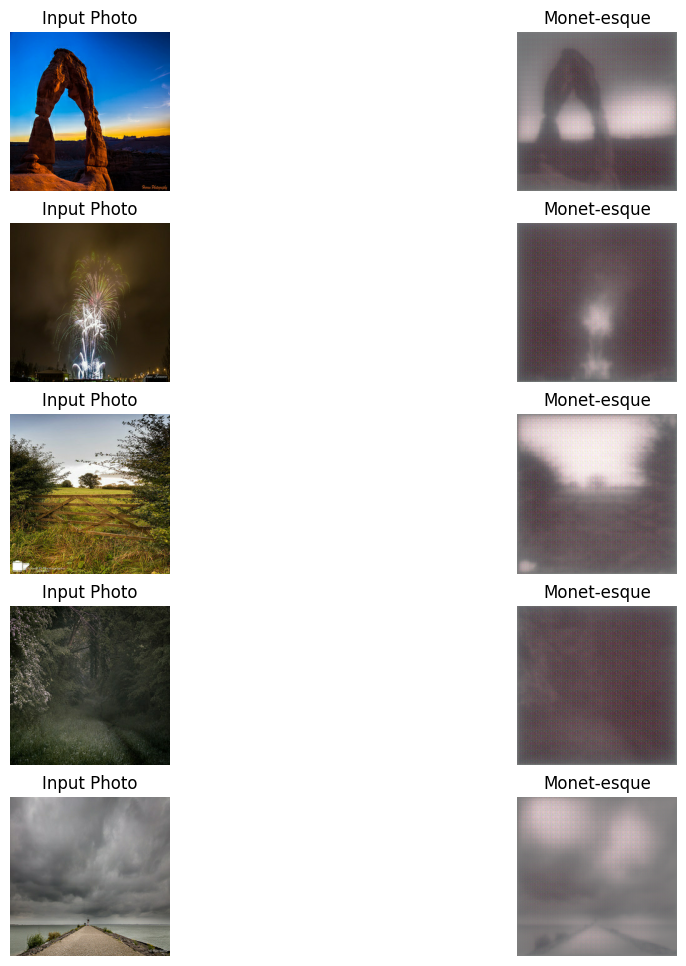

In [25]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

Create a submission file

In [26]:
import PIL
! mkdir ../images

In [ ]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("./images/" + str(i) + ".jpg")
    i += 1

2024-12-04 08:48:46.401884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Conclusion

The project demonstrates the use of generative adversarial networks (GANs) to replicate the distinct styles of artists like Claude Monet. The CycleGAN model is trained on Monet and photo images to generate Monet-esque images from photos. The model is trained for 25 epochs, and the results are displayed for five photo images. The generated Monet-esque images are visually appealing and resemble Monet's style, with vibrant colors and brush strokes. The project showcases the potential of GANs in art and technology, enabling the creation of original artworks and enhancing photos in various styles. The model can be further fine-tuned and optimized to generate more realistic and diverse Monet-esque images, opening up exciting possibilities for art and creativity.